## Set-up

In [1]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()

In [2]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()

    return fig, ax

# Process data

## Data matrix $X$

In [3]:
input_df = pd.read_csv('data/daily_curves.csv', index_col=0)
print(len(input_df))
input_df.head(3)

11653


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,660.975,648.877,658.723,745.817,773.431,828.180,831.509,758.732,669.630,596.548
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,738.739,678.540,666.579,730.333,764.207,819.056,825.176,754.773,706.062,629.708
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,780.816,845.339,798.132,870.231,891.262,980.735,926.445,845.014,756.975,688.183


In [72]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
# df = df[(df.month == '10')&(df.daytype=='Working day')]
print(len(df))
df.head(3)

11653


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,region,year,month,daytype
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,773.431,828.180,831.509,758.732,669.630,596.548,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,764.207,819.056,825.176,754.773,706.062,629.708,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,891.262,980.735,926.445,845.014,756.975,688.183,Calabria,2021,01,Working day


In [73]:
X = df.drop(unit_info.columns, axis=1)
X = X.div(X.sum(axis=1), axis=0)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Calabria_2021-01-02_Saturday,0.036777,0.034244,0.030743,0.029859,0.030434,0.030742,0.032763,0.035012,0.038555,0.043115,...,0.043962,0.043158,0.043813,0.049605,0.051442,0.055083,0.055305,0.050464,0.044538,0.039677
Calabria_2021-01-03_Holiday,0.034650,0.030578,0.028863,0.027986,0.026312,0.029298,0.030882,0.032623,0.035556,0.042865,...,0.049334,0.045314,0.044515,0.048773,0.051035,0.054698,0.055107,0.050405,0.047152,0.042053
Calabria_2021-01-04_Working day,0.030889,0.025722,0.024807,0.024746,0.024875,0.026124,0.029549,0.035732,0.039499,0.050629,...,0.044629,0.048316,0.045618,0.049739,0.050941,0.056055,0.052952,0.048298,0.043266,0.039334
Calabria_2021-01-05_Working day,0.034875,0.031816,0.029953,0.029646,0.028846,0.030038,0.033733,0.039128,0.043183,0.053717,...,0.044944,0.046061,0.044169,0.047396,0.051299,0.051514,0.050242,0.046238,0.039955,0.035533
Calabria_2021-01-06_Holiday,0.033596,0.029647,0.028442,0.028445,0.027932,0.028731,0.029956,0.032832,0.035834,0.046307,...,0.050172,0.047001,0.044419,0.047253,0.051327,0.052310,0.051003,0.048481,0.044442,0.040235


## Initialization matrices $W_{init}$, $H_{init}$

### Initialize $W$ with year-level sector consumption distribution

In [74]:
cons_df = pd.read_excel('data/consumption/consumption_chart.xlsx')
cons_df.head(3)

,Regione,Settore corretto,Sum of Consumo corretto,year,Zone
0,Veneto,Agricoltura,708.884874,2018,North
1,Veneto,Domestico,5595.518524,2018,North
2,Veneto,Industria,14741.332908,2018,North


In [75]:
# Each year features more or less the same sector distribution, so we take arbtrarily the last year
region_cons_df = pd.pivot_table(cons_df[cons_df.year == 2022], values='Sum of Consumo corretto', index='Zone', columns='Settore corretto', aggfunc='sum')
# We remove agriculture since it is too small
region_cons_df.drop('Agricoltura', axis=1, inplace=True)
region_cons_df = region_cons_df.div(region_cons_df.sum(axis=1), axis=0)
region_cons_df

Settore corretto,Domestico,Industria,Servizi
Zone,,,
Calabria,0.418757,0.169124,0.412119
Centre-North,0.227537,0.456270,0.316193
Centre-South,0.296825,0.311082,0.392093
North,0.183974,0.520047,0.295979
Sardinia,0.287522,0.439368,0.273110
Sicily,0.342059,0.353885,0.304057
South,0.255487,0.467103,0.277410


In [76]:
# Now se should find 4 components (according to the FPCA analysis ran before), so we need to add one more.
# Given that Sardinia and South/Sicily have a similar sector mix with different daily curves and that they seem to differ mainly in type of industry, we choose to split the Industry consumption
# From the industry subsector distribution it seems that the "metalli non ferrosi" is responsible of the deviance of Sardinia from South and Sicily

imcei_df = pd.read_excel('/Users/guillaume/Documents/GitHub/BSS/data/consumption/export_imcei_region_chart.xlsx')
imcei_df.head(3)

,Anno,Mese,Zone,Regione,Settore,Tipo Tensione,Imcei Mensile,Consumi (Gwh)
0,2021,Febbraio,North,Lombardia,SIDERURGIA,AT,56.278856,609.47
1,2021,Febbraio,North,Friuli-Venezia Giulia,SIDERURGIA,AT,16.857709,182.56
2,2021,Febbraio,North,Veneto,SIDERURGIA,AT,16.632398,180.12


In [77]:
# Each year features more or less the same sector distribution, so we take arbtrarily the last year
region_imcei_df = pd.pivot_table(imcei_df, values='Consumi (Gwh)', index='Zone', columns='Settore', aggfunc='sum')
region_imcei_df = region_imcei_df.fillna(0).div(region_imcei_df.fillna(0).sum(axis=1), axis=0)
region_imcei_df

Settore,ALIMENTARE,ALTRI,CARTARIA,CEMENTO CALCE E GESSO,CERAMICHE E VETRARIE,CHIMICA,MECCANICA,METALLI NON FERROSI,MEZZI DI TRASPORTO,SIDERURGIA
Zone,,,,,,,,,,
Calabria,0.000000,0.732288,0.000000,0.181330,0.000000,0.086383,0.000000,0.000000,0.000000,0.000000
Centre-North,0.018280,0.149364,0.256549,0.036830,0.048687,0.101659,0.099522,0.115424,0.031796,0.141888
Centre-South,0.033223,0.225481,0.047489,0.090762,0.013459,0.092326,0.035709,0.071985,0.106571,0.282995
North,0.013951,0.138182,0.009241,0.025275,0.023056,0.092524,0.082830,0.086433,0.018670,0.509838
Sardinia,0.030628,0.060916,0.008278,0.042906,0.000000,0.253736,0.037780,0.565756,0.000000,0.000000
Sicily,0.026833,0.274475,0.000000,0.144020,0.000000,0.181337,0.178375,0.018193,0.007023,0.169744
South,0.103417,0.237429,0.010274,0.209634,0.021636,0.070357,0.011814,0.003816,0.103443,0.228179


In [78]:
# region_cons_df['Industria 2'] = region_imcei_df['METALLI NON FERROSI'] * region_cons_df['Industria']
# region_cons_df['Industria 1'] = region_cons_df['Industria'] - region_cons_df['Industria 2']
# region_cons_df = region_cons_df[['Domestico', 'Servizi', 'Industria 1', 'Industria 2']]
region_cons_df.index = region_cons_df.index.str.replace('-', '.')
region_cons_df

Settore corretto,Domestico,Industria,Servizi
Zone,,,
Calabria,0.418757,0.169124,0.412119
Centre.North,0.227537,0.456270,0.316193
Centre.South,0.296825,0.311082,0.392093
North,0.183974,0.520047,0.295979
Sardinia,0.287522,0.439368,0.273110
Sicily,0.342059,0.353885,0.304057
South,0.255487,0.467103,0.277410


In [79]:
skip = True
if not skip:  
    # Let's split the servizi in 2 (maybe for business active during the days and those also active during the evening (like restoration))
    region_cons_df['Servizi 2'] = region_cons_df['Servizi'] / 2
    region_cons_df['Servizi 1'] = region_cons_df['Servizi'] - region_cons_df['Servizi 2']
    region_cons_df = region_cons_df[['Domestico', 'Industria', 'Servizi 1', 'Servizi 2']]
    region_cons_df.index = region_cons_df.index.str.replace('-', '.')
else:
    print("skipped")

skipped


In [80]:
W_init = df[['region']]
W_init = W_init.merge(region_cons_df, how='left', left_on='region', right_index=True)
W_init.drop('region', axis=1, inplace=True)
W_init = W_init.mul(X.sum(axis=1), axis=0)
W_init

,Domestico,Industria,Servizi
Calabria_2021-01-02_Saturday,0.418757,0.169124,0.412119
Calabria_2021-01-03_Holiday,0.418757,0.169124,0.412119
Calabria_2021-01-04_Working day,0.418757,0.169124,0.412119
Calabria_2021-01-05_Working day,0.418757,0.169124,0.412119
Calabria_2021-01-06_Holiday,0.418757,0.169124,0.412119
...,...,...,...
South_2022-12-27_Working day,0.255487,0.467103,0.277410
South_2022-12-28_Working day,0.255487,0.467103,0.277410
South_2022-12-29_Working day,0.255487,0.467103,0.277410
South_2022-12-30_Working day,0.255487,0.467103,0.277410


In [81]:
n_components = 3

### Initialize W with equal values

In [82]:
# /!\ CAUTION /!\: This may cause the algorithm to converge to a local minimum where all the profiles are the same
skip = True
if not skip:
    W_init = pd.DataFrame(index=df.index)
    for k in range(n_components):
        W_init[f'Component {k+1}'] = 1 / n_components
    # Multiply by daily consumption to obtain equal consumption values across components
    W_init = W_init.mul(X.sum(axis=1), axis=0)
    W_init
else:
    print("skipped")

skipped


In [83]:
# Our initial guess for the matrix of components is a constant curve. The condition on the norm of the components being 1 yields S_k = (1/24, ..., 1/24)
H_init = np.ones((n_components, 24)) / 24

# NMF

## Random initialization

1500 iterations
2.710440671412232e-06 error


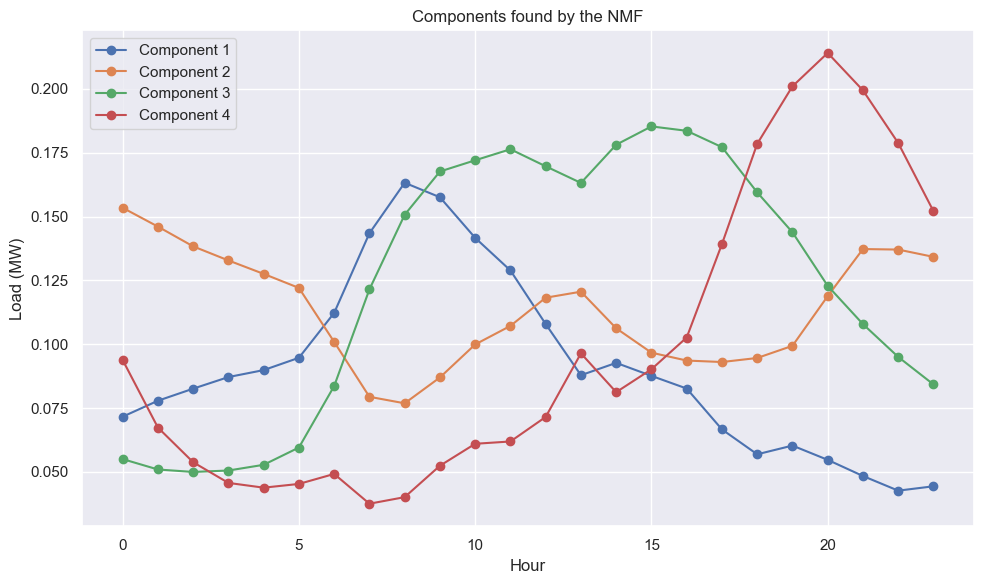

In [34]:
n_components = 4
random_state = None
tol = 1e-5
init = 'random'
max_iter = 4000
solver = 'mu'

fig, axs = plt.subplots(1, 1, figsize=(10, 6))

model = NMF(
    n_components=n_components,
    random_state=random_state,
    solver=solver,
    tol=tol,
    init=init,
    max_iter=max_iter
)

W = model.fit_transform(X)
H = model.components_

print('{} iterations'.format(model.n_iter_))
print('{} error'.format(model.reconstruction_err_/X.size))
plot_components(H, ax=axs, title=f"Components found by the NMF")

plt.tight_layout()

## Initialization with year level sector-wise consumption

### Run NMF

460 iterations
3.3796031999419833e-06 error


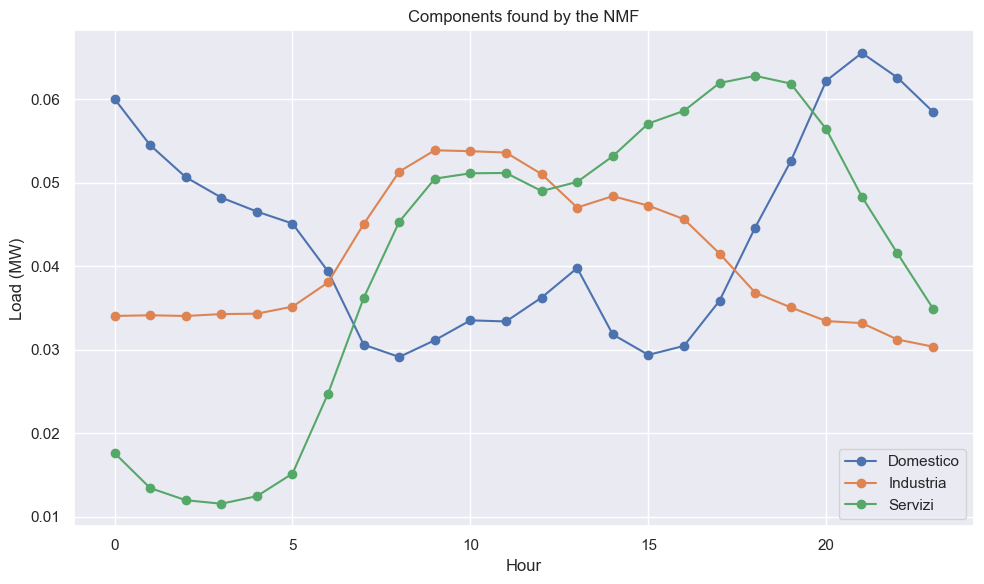

In [84]:
n_components = 3
random_state = None
tol = 1e-5
init = 'custom'
max_iter = 4000
solver = 'mu'
verbose = 0

fig, axs = plt.subplots(1, 1, figsize=(10, 6))

model = NMF(
    n_components=n_components,
    random_state=random_state,
    solver=solver,
    tol=tol,
    init=init,
    max_iter=max_iter,
    verbose=verbose
)

W = model.fit_transform(
    X.values,
    W=W_init.values.copy(order='C'),
    H=H_init
)

H = model.components_

print('{} iterations'.format(model.n_iter_))
print('{} error'.format(model.reconstruction_err_/X.size))
plot_components(H, ax=axs, title=f"Components found by the NMF", component_names=W_init.columns)

plt.tight_layout()

In [85]:
W = pd.DataFrame(W, index=df.index, columns=W_init.columns)
W[unit_info.columns] = df[unit_info.columns]
W

,Domestico,Industria,Servizi,region,year,month,daytype
Calabria_2021-01-02_Saturday,0.376135,0.190319,0.427319,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,0.344277,0.148009,0.505020,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,0.192636,0.272233,0.545155,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,0.223220,0.410422,0.371228,Calabria,2021,01,Working day
Calabria_2021-01-06_Holiday,0.265756,0.275720,0.461955,Calabria,2021,01,Holiday
...,...,...,...,...,...,...,...
South_2022-12-27_Working day,0.219615,0.199938,0.587016,South,2022,12,Working day
South_2022-12-28_Working day,0.155432,0.038369,0.820415,South,2022,12,Working day
South_2022-12-29_Working day,0.254855,0.381765,0.366135,South,2022,12,Working day
South_2022-12-30_Working day,0.298268,0.076789,0.627890,South,2022,12,Working day


In [87]:
region_cons_df

Settore corretto,Domestico,Industria,Servizi
Zone,,,
Calabria,0.418757,0.169124,0.412119
Centre.North,0.227537,0.456270,0.316193
Centre.South,0.296825,0.311082,0.392093
North,0.183974,0.520047,0.295979
Sardinia,0.287522,0.439368,0.273110
Sicily,0.342059,0.353885,0.304057
South,0.255487,0.467103,0.277410


In [88]:
W_region = W.groupby('region')[['Domestico', 'Industria', 'Servizi']].sum()
W_region = W_region.div(W_region.sum(axis=1), axis=0)
W_region

,Domestico,Industria,Servizi
region,,,
Calabria,0.310943,0.324652,0.364405
Centre.North,0.207935,0.452778,0.339287
Centre.South,0.279447,0.339054,0.381499
North,0.203414,0.482923,0.313663
Sardinia,0.311256,0.449295,0.239449
Sicily,0.351322,0.327933,0.320745
South,0.320259,0.367659,0.312082


Calabria             Axes(0.1,0.679412;0.235294x0.220588)
Centre.North    Axes(0.382353,0.679412;0.235294x0.220588)
Centre.South    Axes(0.664706,0.679412;0.235294x0.220588)
North                Axes(0.1,0.414706;0.235294x0.220588)
Sardinia        Axes(0.382353,0.414706;0.235294x0.220588)
Sicily          Axes(0.664706,0.414706;0.235294x0.220588)
South                    Axes(0.1,0.15;0.235294x0.220588)
dtype: object

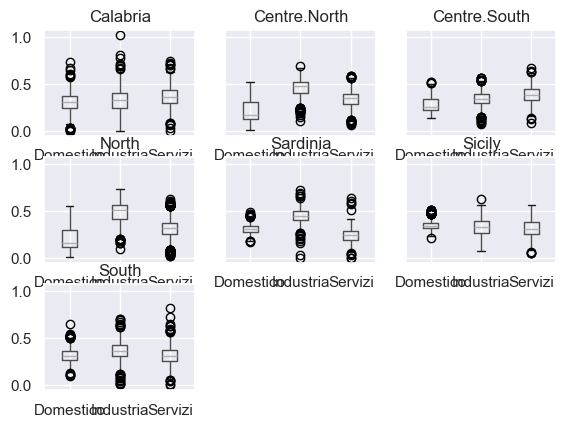

In [89]:
W.groupby('region')[['Domestico', 'Industria', 'Servizi']].boxplot()

In [90]:
W_daytype = W.groupby('daytype')[['Domestico', 'Industria', 'Servizi']].sum()
W_daytype = W_daytype.div(W_daytype.sum(axis=1), axis=0)
W_daytype

,Domestico,Industria,Servizi
daytype,,,
Holiday,0.402811,0.339420,0.257769
Saturday,0.339403,0.411435,0.249162
Working day,0.240535,0.409826,0.349639


In [101]:
W_daytype = W[W['daytype'] == 'Working day'].groupby(['region', 'month'])[['Domestico', 'Industria', 'Servizi']].sum()
W_daytype = W_daytype.div(W_daytype.sum(axis=1), axis=0).round(2)
# W_daytype
W_daytype.unstack(level='region').T

month                     01    02    03    04    05    06    07    08    09  \
          region                                                               
Domestico Calabria      0.20  0.24  0.29  0.31  0.32  0.29  0.32  0.35  0.30   
          Centre.North  0.11  0.12  0.15  0.17  0.15  0.14  0.14  0.22  0.14   
          Centre.South  0.20  0.23  0.27  0.28  0.25  0.23  0.22  0.27  0.23   
          North         0.09  0.10  0.14  0.16  0.15  0.15  0.16  0.22  0.14   
          Sardinia      0.26  0.28  0.30  0.30  0.30  0.29  0.30  0.35  0.30   
          Sicily        0.32  0.34  0.35  0.35  0.32  0.31  0.34  0.36  0.32   
          South         0.26  0.27  0.32  0.32  0.29  0.28  0.29  0.30  0.29   
Industria Calabria      0.35  0.31  0.29  0.35  0.36  0.34  0.34  0.31  0.36   
          Centre.North  0.46  0.48  0.48  0.48  0.50  0.49  0.48  0.42  0.49   
          Centre.South  0.30  0.31  0.31  0.36  0.40  0.39  0.38  0.37  0.39   
          North         0.51  0.53  0.50  0.51  0.52  0.51  0.50  0.45  0.52   
          Sardinia      0.41  0.43  0.42  0.49  0.52  0.50  0.45  0.42  0.49   
          Sicily        0.22  0.25  0.28  0.35  0.42  0.40  0.38  0.38  0.38   
          South         0.32  0.32  0.33  0.39  0.42  0.42  0.43  0.41  0.42   
Servizi   Calabria      0.45  0.46  0.42  0.34  0.32  0.37  0.34  0.34  0.34   
          Centre.North  0.43  0.40  0.37  0.34  0.36  0.36  0.38  0.36  0.37   
          Centre.South  0.50  0.46  0.42  0.36  0.35  0.38  0.40  0.37  0.39   
          North         0.40  0.38  0.36  0.33  0.34  0.35  0.34  0.33  0.34   
          Sardinia      0.33  0.30  0.28  0.21  0.18  0.21  0.25  0.24  0.21   
          Sicily        0.46  0.41  0.37  0.30  0.26  0.29  0.28  0.27  0.30   
          South         0.42  0.40  0.35  0.29  0.29  0.30  0.29  0.29  0.29   

month                     10    11    12  
          region                          
Domestico Calabria      0.27  0.21  0.24  
          Centre.North  0.14  0.12  0.12  
          Centre.South  0.25  0.22  0.22  
          North         0.12  0.09  0.10  
          Sardinia      0.30  0.28  0.27  
          Sicily        0.32  0.32  0.32  
          South         0.31  0.28  0.26  
Industria Calabria      0.37  0.35  0.38  
          Centre.North  0.48  0.47  0.48  
          Centre.South  0.36  0.32  0.31  
          North         0.51  0.51  0.51  
          Sardinia      0.49  0.44  0.42  
          Sicily        0.36  0.27  0.25  
          South         0.36  0.31  0.31  
Servizi   Calabria      0.36  0.45  0.38  
          Centre.North  0.38  0.42  0.40  
          Centre.South  0.40  0.46  0.47  
          North         0.37  0.41  0.40  
          Sardinia      0.21  0.28  0.31  
          Sicily        0.32  0.41  0.44  
          South         0.33  0.40  0.43

___

# Tests

In [26]:
X.sample(20)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Centre.South_2018-05-02_Working day,3754.938,3491.426,3296.691,3232.197,3281.957,3489.861,3985.796,4601.828,5414.013,5655.903,...,5366.999,5476.170,5653.305,5633.075,5519.180,5680.797,5929.420,5845.630,5276.773,4923.575
South_2018-03-10_Saturday,3253.036,2615.978,2604.888,2473.834,2445.855,2500.512,2760.953,2910.301,3289.647,3597.116,...,3059.953,3012.547,3065.233,3116.973,3625.611,4014.097,3963.127,3744.801,3451.206,3170.949
South_2021-07-31_Saturday,3257.143,3133.001,3049.768,2852.342,2737.744,2842.544,2791.015,3003.913,3400.955,3772.022,...,3983.490,4071.567,4114.083,4143.364,3963.377,3903.509,3745.140,3836.290,3545.967,3375.591
South_2021-11-24_Working day,2261.356,2054.142,1938.043,1934.981,1950.442,2075.212,2378.389,2532.326,2829.659,2881.610,...,2947.156,3080.424,3040.843,3344.392,3371.223,3347.508,3284.286,3142.660,2905.394,2665.366
Sardinia_2020-11-24_Working day,902.423,843.436,813.091,808.707,821.583,844.293,933.750,1058.518,1189.116,1273.100,...,1146.206,1157.911,1120.702,1200.043,1253.806,1264.683,1277.041,1212.430,1087.157,991.738
Centre.South_2020-04-25_Holiday,3915.622,3551.299,3323.681,3176.431,3080.537,3088.252,2980.011,2972.499,3353.222,3719.929,...,3950.371,3724.074,3791.463,3940.233,4045.522,4533.708,5287.858,4980.827,4443.560,4066.533
South_2018-02-12_Working day,2798.621,2570.414,2487.119,2462.462,2520.215,2527.992,3028.723,3345.427,3722.780,3748.313,...,3586.539,3940.844,3885.615,3754.947,4374.526,4212.768,4206.241,3979.080,3655.201,3347.660
Centre.North_2022-08-02_Working day,3109.648,2824.898,2663.803,2618.384,2600.934,2679.004,2898.220,3360.166,3963.813,4438.831,...,4593.075,4757.449,4781.273,4915.532,4414.229,4139.699,4041.823,3899.836,3667.274,3397.883
Centre.North_2022-08-28_Holiday,2403.344,2251.527,2120.836,2047.653,2033.461,2034.740,2082.469,2063.322,2310.285,2658.710,...,2603.887,2596.929,2635.028,3099.238,2960.555,2845.754,3008.954,2941.871,2746.732,2569.339
Calabria_2022-11-23_Working day,558.190,515.171,504.938,478.238,507.616,516.412,553.161,615.966,713.164,832.482,...,697.234,681.213,699.762,767.086,760.757,765.619,797.735,722.431,665.860,598.083


In [194]:
W_init.info()

<class 'pandas.core.frame.DataFrame'>
Index: 702 entries, Calabria_2021-10-01_Working day to South_2022-10-31_Working day
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Domestico    702 non-null    float64
 1   Servizi      702 non-null    float64
 2   Industria 1  702 non-null    float64
 3   Industria 2  702 non-null    float64
dtypes: float64(4)
memory usage: 27.4+ KB


In [189]:
W_init[W_init.isnull().any(axis=1)]

,Domestico,Servizi,Industria 1,Industria 2
Centre.North_2018-10-01_Working day,NaN,NaN,NaN,NaN
Centre.North_2018-10-02_Working day,NaN,NaN,NaN,NaN
Centre.North_2018-10-03_Working day,NaN,NaN,NaN,NaN
Centre.North_2018-10-04_Working day,NaN,NaN,NaN,NaN
Centre.North_2018-10-05_Working day,NaN,NaN,NaN,NaN
...,...,...,...,...
Centre.South_2022-10-25_Working day,NaN,NaN,NaN,NaN
Centre.South_2022-10-26_Working day,NaN,NaN,NaN,NaN
Centre.South_2022-10-27_Working day,NaN,NaN,NaN,NaN
Centre.South_2022-10-28_Working day,NaN,NaN,NaN,NaN


In [136]:
W_init.values.copy(order='C')

array([[ 5501.65616164,  5414.44777534,  2221.97013699,     0.        ],
       [ 5501.65616164,  5414.44777534,  2221.97013699,     0.        ],
       [ 5501.65616164,  5414.44777534,  2221.97013699,     0.        ],
       ...,
       [13438.25782466, 14591.37052329, 24475.18123511,    93.75614571],
       [13438.25782466, 14591.37052329, 24475.18123511,    93.75614571],
       [13438.25782466, 14591.37052329, 24475.18123511,    93.75614571]])

In [137]:
W_init

,Domestico,Servizi,Industria 1,Industria 2
Calabria_2021-10-01_Working day,5501.656162,5414.447775,2221.970137,0.000000
Calabria_2021-10-04_Working day,5501.656162,5414.447775,2221.970137,0.000000
Calabria_2021-10-05_Working day,5501.656162,5414.447775,2221.970137,0.000000
Calabria_2021-10-06_Working day,5501.656162,5414.447775,2221.970137,0.000000
Calabria_2021-10-07_Working day,5501.656162,5414.447775,2221.970137,0.000000
...,...,...,...,...
South_2022-10-25_Working day,13438.257825,14591.370523,24475.181235,93.756146
South_2022-10-26_Working day,13438.257825,14591.370523,24475.181235,93.756146
South_2022-10-27_Working day,13438.257825,14591.370523,24475.181235,93.756146
South_2022-10-28_Working day,13438.257825,14591.370523,24475.181235,93.756146


In [135]:
H_init

array([[0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667],
       [0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667],
       [0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667],
       [0.041

In [98]:
import sklearn
print(sklearn.__version__)

1.3.2


In [133]:
H_init.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [78]:
df.dtype

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [70]:
np.ones((3,4))

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [80]:
unit_info = X.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(X.index)
df = pd.concat([X, unit_info], axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,region,year,month,daytype
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,773.431,828.180,831.509,758.732,669.630,596.548,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,764.207,819.056,825.176,754.773,706.062,629.708,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,891.262,980.735,926.445,845.014,756.975,688.183,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,601.762,548.971,516.841,511.542,497.733,518.294,582.056,675.144,745.112,926.874,...,885.152,888.862,866.911,797.831,689.408,613.111,Calabria,2021,01,Working day
Calabria_2021-01-06_Holiday,522.253,460.861,442.133,442.172,434.206,446.617,465.662,510.365,557.035,719.846,...,797.872,813.154,792.839,753.642,690.855,625.452,Calabria,2021,01,Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
South_2022-12-27_Working day,1308.316,1196.696,1118.799,1120.978,1261.263,1301.362,1596.961,1820.374,2114.503,2419.050,...,2609.307,2646.229,2607.138,2485.261,2204.701,1928.912,South,2022,12,Working day
South_2022-12-28_Working day,1414.026,1224.167,1015.749,955.943,936.003,1024.786,1263.846,1629.519,2071.388,2444.281,...,3033.573,3064.172,3021.570,2853.291,2550.622,2062.207,South,2022,12,Working day
South_2022-12-29_Working day,1825.454,1392.857,1556.300,1471.466,1446.057,1525.885,1747.927,1865.976,2035.924,2345.770,...,2425.699,2538.385,2462.135,2344.187,2048.957,1735.955,South,2022,12,Working day
South_2022-12-30_Working day,1528.905,1225.758,1115.273,1035.417,1050.114,1129.062,1317.993,1661.784,1885.976,2393.216,...,2543.212,2623.629,2664.239,2492.585,2206.210,2122.022,South,2022,12,Working day
